<a href="https://colab.research.google.com/github/AbdoAlkayal/Machine_Learning/blob/main/GenerateFaces(DCGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Path to your zip file in Google Drive
zip_path = '/content/drive/MyDrive/img_align_celeba.zip'

In [ ]:
!unzip -q '/content/drive/MyDrive/img_align_celeba.zip' -d '/content/celeba_data'


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
IMG_SIZE = 64
NOISE_DIM = 100
EPOCHS = 50
NUM_EXAMPLES_TO_GENERATE = 16

def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

def load_celeba_dataset(image_dir, max_images=10000):
    print(f"Loading up to {max_images} images from {image_dir} ...")
    file_paths = tf.data.Dataset.list_files(os.path.join(image_dir, '*.jpg'), shuffle=True)
    file_paths = file_paths.take(max_images)  # Limit to 10,000 images
    dataset = file_paths.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print(f"Dataset loaded with {max_images} images (~{max_images // BATCH_SIZE} batches)")
    return dataset

celeba_folder = '/content/celeba_data/img_align_celeba'  # Adjust if different
train_dataset = load_celeba_dataset(celeba_folder, max_images=10000)

Loading up to 10000 images from /content/celeba_data/img_align_celeba ...
Dataset loaded with 10000 images (~78 batches)


In [ ]:
for batch in train_dataset.take(1):
    print(batch.shape)

(128, 64, 64, 3)


In [ ]:
image_count = 0
for batch in train_dataset:
    image_count += batch.shape[0]  # batch.shape[0] is the number of images in the batch

print(f"Total number of images in train_dataset: {image_count}")

Total number of images in train_dataset: 10000


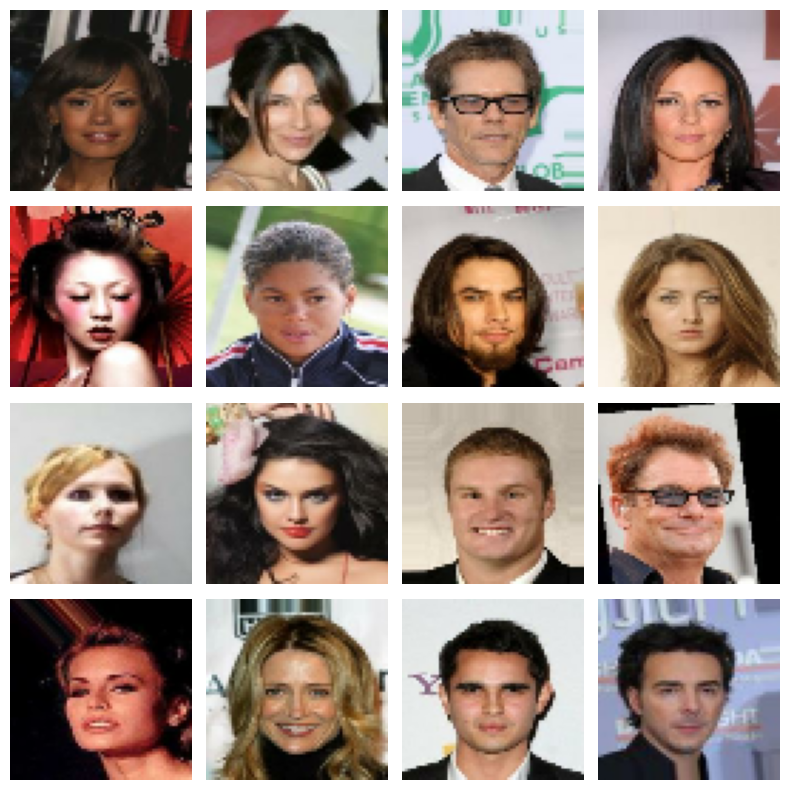

In [ ]:
# Show a batch of images from the train_dataset
def show_batch(dataset, num_images=16):
    for image_batch in dataset.take(1):  # Take one batch
        image_batch = (image_batch + 1.0) / 2.0  # Denormalize from [-1, 1] to [0, 1]
        plt.figure(figsize=(8, 8))
        for i in range(num_images):
            plt.subplot(4, 4, i + 1)
            plt.imshow(image_batch[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# Call the function
show_batch(train_dataset)

In [ ]:
# --- Generator model ---

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4, 1024)))  # 4x4x1024

    model.add(layers.Conv2DTranspose(512, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())  # 8x8x512

    model.add(layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())  # 16x16x256

    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())  # 32x32x128

    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))  # 64x64x3

    return model

In [ ]:
generator = make_generator_model()
print("Generator summary:")
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Generator summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │    13,107,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         9,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,920,320 (72.18 MB)

 Trainable params: 18,885,760 (72.04 MB)

 Non-trainable params: 34,560 (135.00 KB)

In [ ]:
# --- Discriminator model ---

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same',
                            input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5,5), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model


In [ ]:
discriminator = make_discriminator_model()
print("Discriminator summary:")
discriminator.summary()

Discriminator summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,314,753 (16.46 MB)

 Trainable params: 4,314,753 (16.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

In [ ]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0  # Rescale to [0, 1]

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()

In [ ]:
# Fixed seed for consistent image generation during training
seed = tf.random.normal([16, NOISE_DIM])

In [ ]:
# --- Training function ---
SAVE_FREQ = 5
def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(1, epochs+1):
        print(f'\nStarting epoch {epoch}/{epochs}')
        epoch_gen_loss_avg = tf.keras.metrics.Mean()
        epoch_disc_loss_avg = tf.keras.metrics.Mean()

        step = 0
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss_avg.update_state(gen_loss)
            epoch_disc_loss_avg.update_state(disc_loss)
            step += 1
            if step % 50 == 0:
                print(f"  Step {step}: Generator loss = {gen_loss:.4f}, Discriminator loss = {disc_loss:.4f}")

        gen_losses.append(epoch_gen_loss_avg.result())
        disc_losses.append(epoch_disc_loss_avg.result())

        print(f'Epoch {epoch} summary:')
        print(f'  Generator Loss: {epoch_gen_loss_avg.result():.4f}')
        print(f'  Discriminator Loss: {epoch_disc_loss_avg.result():.4f}')

        if epoch % SAVE_FREQ == 0 or epoch == 1:
            print(f"Generating sample images at epoch {epoch}...")
            generate_and_save_images(generator, epoch, seed)

    # Plot loss history
    plt.figure(figsize=(10,5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses')
    plt.show()

    ##Generate final images after training
    print("Generating final images after training...")
    generate_and_save_images(generator, epochs, seed)

Starting training...

Starting epoch 1/50
  Step 50: Generator loss = 1.7498, Discriminator loss = 0.6461
Epoch 1 summary:
  Generator Loss: 1.4183
  Discriminator Loss: 0.9214
Generating sample images at epoch 1...


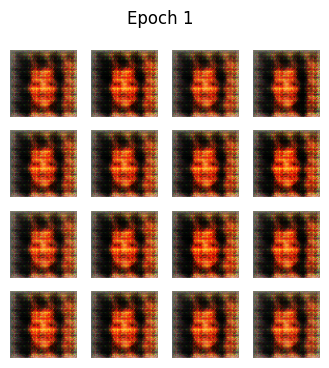


Starting epoch 2/50
  Step 50: Generator loss = 1.3635, Discriminator loss = 0.7413
Epoch 2 summary:
  Generator Loss: 1.4554
  Discriminator Loss: 0.9222

Starting epoch 3/50
  Step 50: Generator loss = 0.9243, Discriminator loss = 0.9273
Epoch 3 summary:
  Generator Loss: 1.3716
  Discriminator Loss: 0.8929

Starting epoch 4/50
  Step 50: Generator loss = 1.3968, Discriminator loss = 1.0912
Epoch 4 summary:
  Generator Loss: 1.5770
  Discriminator Loss: 0.8442

Starting epoch 5/50
  Step 50: Generator loss = 1.0188, Discriminator loss = 0.9454
Epoch 5 summary:
  Generator Loss: 1.1363
  Discriminator Loss: 1.0039
Generating sample images at epoch 5...


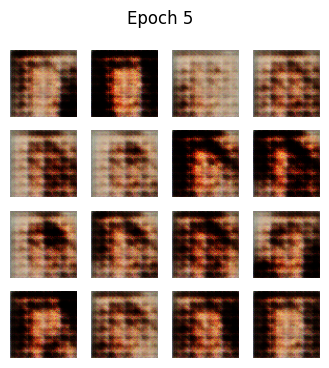


Starting epoch 6/50
  Step 50: Generator loss = 1.2505, Discriminator loss = 1.2205
Epoch 6 summary:
  Generator Loss: 1.1284
  Discriminator Loss: 1.0573

Starting epoch 7/50
  Step 50: Generator loss = 1.1518, Discriminator loss = 1.0829
Epoch 7 summary:
  Generator Loss: 1.1091
  Discriminator Loss: 1.0494

Starting epoch 8/50
  Step 50: Generator loss = 1.1265, Discriminator loss = 1.0911
Epoch 8 summary:
  Generator Loss: 1.1355
  Discriminator Loss: 1.0657

Starting epoch 9/50
  Step 50: Generator loss = 1.1505, Discriminator loss = 1.0439
Epoch 9 summary:
  Generator Loss: 1.1194
  Discriminator Loss: 1.0696

Starting epoch 10/50
  Step 50: Generator loss = 1.1970, Discriminator loss = 0.9559
Epoch 10 summary:
  Generator Loss: 1.1422
  Discriminator Loss: 1.0287
Generating sample images at epoch 10...


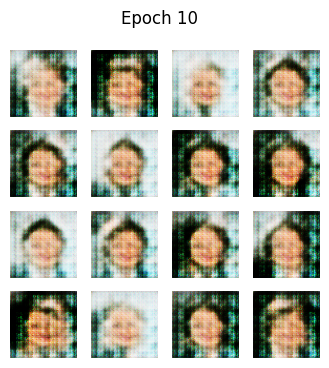


Starting epoch 11/50
  Step 50: Generator loss = 0.9467, Discriminator loss = 1.0511
Epoch 11 summary:
  Generator Loss: 1.0637
  Discriminator Loss: 1.1430

Starting epoch 12/50
  Step 50: Generator loss = 0.9799, Discriminator loss = 1.1023
Epoch 12 summary:
  Generator Loss: 1.1752
  Discriminator Loss: 1.0591

Starting epoch 13/50
  Step 50: Generator loss = 0.9371, Discriminator loss = 1.0823
Epoch 13 summary:
  Generator Loss: 1.0992
  Discriminator Loss: 1.0771

Starting epoch 14/50
  Step 50: Generator loss = 0.9893, Discriminator loss = 1.2958
Epoch 14 summary:
  Generator Loss: 1.0600
  Discriminator Loss: 1.0947

Starting epoch 15/50
  Step 50: Generator loss = 1.0853, Discriminator loss = 1.0950
Epoch 15 summary:
  Generator Loss: 1.0959
  Discriminator Loss: 1.0264
Generating sample images at epoch 15...


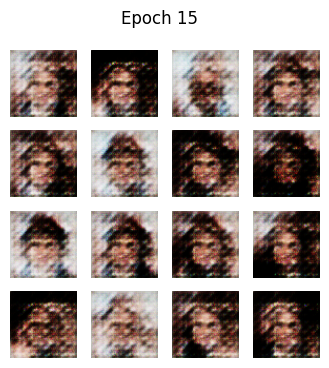


Starting epoch 16/50
  Step 50: Generator loss = 0.9916, Discriminator loss = 1.0081
Epoch 16 summary:
  Generator Loss: 1.1513
  Discriminator Loss: 1.0666

Starting epoch 17/50
  Step 50: Generator loss = 1.1294, Discriminator loss = 1.2302
Epoch 17 summary:
  Generator Loss: 1.1600
  Discriminator Loss: 0.9968

Starting epoch 18/50
  Step 50: Generator loss = 0.8543, Discriminator loss = 1.4925
Epoch 18 summary:
  Generator Loss: 1.1264
  Discriminator Loss: 1.1083

Starting epoch 19/50
  Step 50: Generator loss = 1.0944, Discriminator loss = 0.8543
Epoch 19 summary:
  Generator Loss: 1.1528
  Discriminator Loss: 0.9969

Starting epoch 20/50
  Step 50: Generator loss = 1.1346, Discriminator loss = 1.0198
Epoch 20 summary:
  Generator Loss: 1.3697
  Discriminator Loss: 0.9470
Generating sample images at epoch 20...


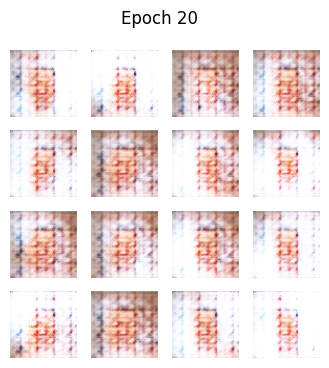


Starting epoch 21/50
  Step 50: Generator loss = 1.6277, Discriminator loss = 0.5819
Epoch 21 summary:
  Generator Loss: 1.4528
  Discriminator Loss: 0.8301

Starting epoch 22/50
  Step 50: Generator loss = 1.6559, Discriminator loss = 0.7318
Epoch 22 summary:
  Generator Loss: 1.4310
  Discriminator Loss: 0.9357

Starting epoch 23/50
  Step 50: Generator loss = 2.0198, Discriminator loss = 1.5373
Epoch 23 summary:
  Generator Loss: 1.3627
  Discriminator Loss: 1.0296

Starting epoch 24/50
  Step 50: Generator loss = 2.0615, Discriminator loss = 0.9634
Epoch 24 summary:
  Generator Loss: 1.4419
  Discriminator Loss: 1.0784

Starting epoch 25/50
  Step 50: Generator loss = 1.4129, Discriminator loss = 0.9120
Epoch 25 summary:
  Generator Loss: 1.5588
  Discriminator Loss: 0.9076
Generating sample images at epoch 25...


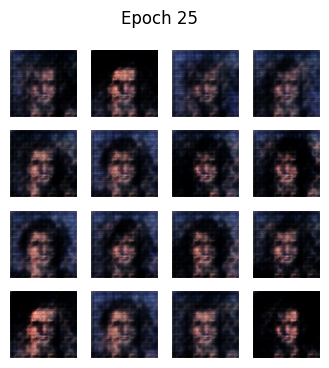


Starting epoch 26/50
  Step 50: Generator loss = 1.0680, Discriminator loss = 1.0614
Epoch 26 summary:
  Generator Loss: 1.2469
  Discriminator Loss: 1.0346

Starting epoch 27/50
  Step 50: Generator loss = 1.3398, Discriminator loss = 0.9716
Epoch 27 summary:
  Generator Loss: 1.2035
  Discriminator Loss: 0.9797

Starting epoch 28/50
  Step 50: Generator loss = 1.7060, Discriminator loss = 0.9117
Epoch 28 summary:
  Generator Loss: 1.3189
  Discriminator Loss: 0.9155

Starting epoch 29/50
  Step 50: Generator loss = 2.7360, Discriminator loss = 2.2101
Epoch 29 summary:
  Generator Loss: 1.3817
  Discriminator Loss: 0.9356

Starting epoch 30/50
  Step 50: Generator loss = 1.5143, Discriminator loss = 1.2054
Epoch 30 summary:
  Generator Loss: 1.5850
  Discriminator Loss: 0.8015
Generating sample images at epoch 30...


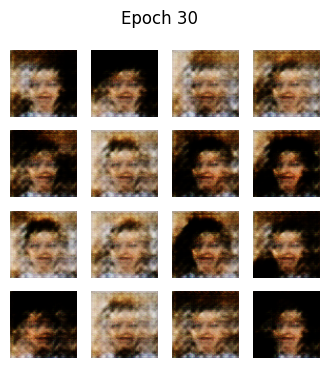


Starting epoch 31/50
  Step 50: Generator loss = 1.0785, Discriminator loss = 0.9979
Epoch 31 summary:
  Generator Loss: 1.3726
  Discriminator Loss: 0.9352

Starting epoch 32/50
  Step 50: Generator loss = 1.3737, Discriminator loss = 0.7989
Epoch 32 summary:
  Generator Loss: 1.3702
  Discriminator Loss: 0.9329

Starting epoch 33/50
  Step 50: Generator loss = 1.2001, Discriminator loss = 1.0763
Epoch 33 summary:
  Generator Loss: 1.3208
  Discriminator Loss: 0.9385

Starting epoch 34/50
  Step 50: Generator loss = 0.7851, Discriminator loss = 1.2254
Epoch 34 summary:
  Generator Loss: 1.3658
  Discriminator Loss: 1.0012

Starting epoch 35/50
  Step 50: Generator loss = 1.4742, Discriminator loss = 0.7857
Epoch 35 summary:
  Generator Loss: 1.4200
  Discriminator Loss: 0.8847
Generating sample images at epoch 35...


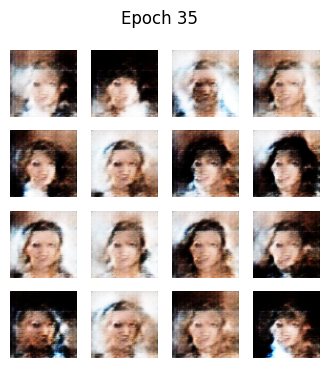


Starting epoch 36/50
  Step 50: Generator loss = 1.3867, Discriminator loss = 0.8725
Epoch 36 summary:
  Generator Loss: 1.3694
  Discriminator Loss: 0.9605

Starting epoch 37/50
  Step 50: Generator loss = 1.3935, Discriminator loss = 0.6900
Epoch 37 summary:
  Generator Loss: 1.3577
  Discriminator Loss: 0.9338

Starting epoch 38/50
  Step 50: Generator loss = 1.2677, Discriminator loss = 0.7563
Epoch 38 summary:
  Generator Loss: 1.3481
  Discriminator Loss: 0.9503

Starting epoch 39/50
  Step 50: Generator loss = 1.4161, Discriminator loss = 0.8567
Epoch 39 summary:
  Generator Loss: 1.3681
  Discriminator Loss: 0.9489

Starting epoch 40/50
  Step 50: Generator loss = 1.3532, Discriminator loss = 0.8496
Epoch 40 summary:
  Generator Loss: 1.4759
  Discriminator Loss: 0.8630
Generating sample images at epoch 40...


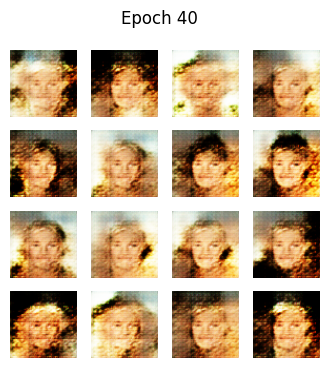


Starting epoch 41/50
  Step 50: Generator loss = 1.5850, Discriminator loss = 0.7744
Epoch 41 summary:
  Generator Loss: 1.5785
  Discriminator Loss: 0.8327

Starting epoch 42/50
  Step 50: Generator loss = 1.4403, Discriminator loss = 0.7210
Epoch 42 summary:
  Generator Loss: 1.4952
  Discriminator Loss: 0.8510

Starting epoch 43/50
  Step 50: Generator loss = 1.7542, Discriminator loss = 0.8087
Epoch 43 summary:
  Generator Loss: 1.4671
  Discriminator Loss: 0.9674

Starting epoch 44/50
  Step 50: Generator loss = 1.5155, Discriminator loss = 0.7761
Epoch 44 summary:
  Generator Loss: 1.6306
  Discriminator Loss: 0.8169

Starting epoch 45/50
  Step 50: Generator loss = 1.6914, Discriminator loss = 0.4577
Epoch 45 summary:
  Generator Loss: 1.5817
  Discriminator Loss: 0.8231
Generating sample images at epoch 45...


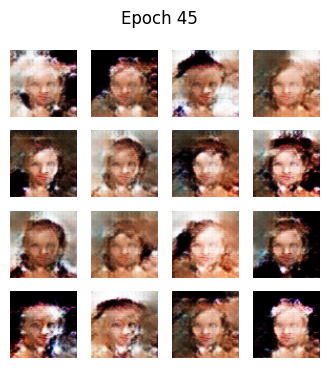


Starting epoch 46/50
  Step 50: Generator loss = 1.5906, Discriminator loss = 0.8875
Epoch 46 summary:
  Generator Loss: 1.5917
  Discriminator Loss: 0.8407

Starting epoch 47/50
  Step 50: Generator loss = 1.9304, Discriminator loss = 0.4572
Epoch 47 summary:
  Generator Loss: 1.7124
  Discriminator Loss: 0.7864

Starting epoch 48/50
  Step 50: Generator loss = 1.8201, Discriminator loss = 0.7149
Epoch 48 summary:
  Generator Loss: 1.6016
  Discriminator Loss: 0.7963

Starting epoch 49/50
  Step 50: Generator loss = 1.6174, Discriminator loss = 0.6970
Epoch 49 summary:
  Generator Loss: 1.6288
  Discriminator Loss: 0.8355

Starting epoch 50/50
  Step 50: Generator loss = 1.0619, Discriminator loss = 1.0253
Epoch 50 summary:
  Generator Loss: 1.6249
  Discriminator Loss: 0.8284
Generating sample images at epoch 50...


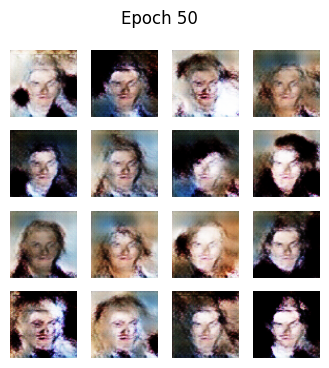

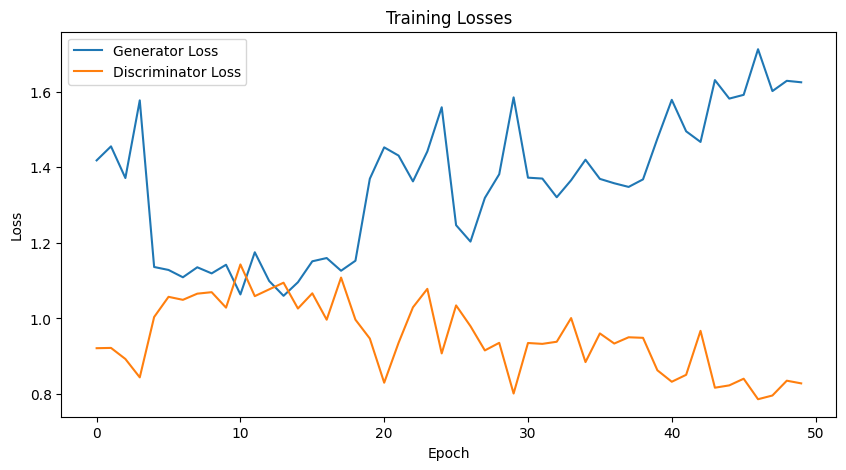

Generating final images after training...


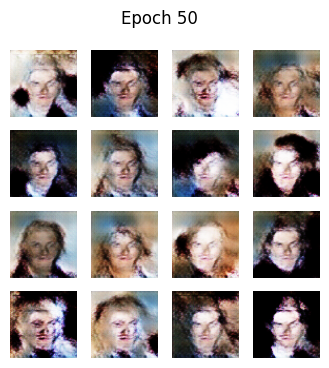

Training completed.


In [ ]:
print("Starting training...")
train(train_dataset, EPOCHS)
print("Training completed.")